<a href="https://colab.research.google.com/github/lphuong304/CS114.L21/blob/main/COLAB_ASSIGNMENTS/COLAB_ASSIGNMENT_17_05/Solution02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 align="center"><b>BÀI TẬP COLAB SỐ 03 - 17/05/2021</b></h1>
<h1 align="center"><b>PREDICT FINAL SCORE OF IT001</b></h1>

###LỚP: CS114.L21
###NHÓM:
1. Nguyễn Ngọc Lan Phương - *19520227*
2. Hoàng Anh Tú - *19522450*
3. Nguyễn Quốc Huy - *19521623*

Nguồn tham khảo:




Link data:
* Data wecode: [link](https://raw.githubusercontent.com/lphuong304/CS114.L21/main/COLAB_ASSIGNMENTS/data%20IT001/wecode.csv)
* Data score: [link](https://raw.githubusercontent.com/lphuong304/CS114.L21/main/COLAB_ASSIGNMENTS/data%20IT001/wecode.csv)

* Ý tưởng:
Lọc các cột data không cần thiết. Chúng em quyết định là số dữ liệu **SOLVED/TRIES** sẽ quyết định đến việc ảnh hưởng **điểm thi CUỐI KỲ** của mỗi học sinh  

References:
1. [Import Package and Visualize Data](#import)
2. [Pre-processing Data](#process)
3. [Traning Model and Testing](#model)

#1. IMPORT PACKAGE AND VISUALIZE DATA
<a name='import'></a>

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import  accuracy_score
import warnings
warnings.filterwarnings('ignore')

**Check data**

In [ ]:
data_score = pd.read_csv('https://raw.githubusercontent.com/lphuong304/CS114.L21/main/COLAB_ASSIGNMENTS/data%20IT001/score_training.csv')
data = pd.read_csv('https://raw.githubusercontent.com/lphuong304/CS114.L21/main/COLAB_ASSIGNMENTS/data%20IT001/wecode.csv')

In [ ]:
data.head(10).T

,0,1,2,3,4,5,6,7,8,9
id,4,5,6,7,8,9,10,11,12,13
assignment_id,0,0,0,0,0,0,0,0,0,0
problem_id,3,4,5,5,5,5,6,7,8,9
user_id,4,4,4,4,4,4,4,4,4,4
is_final,1,1,0,0,0,0,1,1,1,1
status,SCORE,SCORE,Compilation Error,Compilation Error,Compilation Error,Compilation Error,SCORE,SCORE,SCORE,SCORE
pre_score,10000,10000,0,0,0,0,10000,10000,10000,10000
coefficient,100,100,100,100,100,100,100,100,100,100
file_name,solution-0,solution-1,solution-2,solution-3,solution-4,solution-5,solution-6,solution-7,solution-8,solution-9
language_id,2,2,2,2,2,2,2,2,2,2


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264606 entries, 0 to 264605
Data columns (total 12 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             264606 non-null  int64 
 1   assignment_id  264606 non-null  int64 
 2   problem_id     264606 non-null  int64 
 3   user_id        264606 non-null  int64 
 4   is_final       264606 non-null  int64 
 5   status         264605 non-null  object
 6   pre_score      264606 non-null  int64 
 7   coefficient    264606 non-null  object
 8   file_name      264606 non-null  object
 9   language_id    264606 non-null  int64 
 10  created_at     264606 non-null  object
 11  updated_at     264606 non-null  object
dtypes: int64(7), object(5)
memory usage: 24.2+ MB


**Data Discovery**

In [ ]:
data = data.drop(columns=['id', 'created_at', 'updated_at', 'file_name', 'language_id'])

In [ ]:
#create raw data for visualize them to analys
raw_tries = pd.DataFrame({'tries' : data['user_id'].value_counts()})

data['coefficient'] = pd.to_numeric(data['coefficient'], errors='coerce')
raw_coef = data['coefficient']

raw_solved = data[['user_id', 'is_final', 'pre_score']]
raw_solved =  raw_solved[raw_solved['is_final'] > 0]
raw_solved = raw_solved[raw_solved['pre_score'] == 10000]
raw_solved = raw_solved.groupby('user_id').sum()
raw_solved = raw_solved['is_final']


raw_status = data['status']
raw_true_final = data['is_final'] #catergory

data_score['CK'] = pd.to_numeric(data_score['CK'], errors='coerce')
raw_ck = data_score['CK']


#analytics data

In [ ]:
data.describe()

,assignment_id,problem_id,user_id,is_final,pre_score,coefficient
count,264606.000000,264606.000000,264606.000000,264606.000000,264606.000000,264354.000000
mean,186.732429,257.958074,935.002147,0.387349,5596.454559,98.773883
std,109.768713,158.359795,514.246324,0.487146,4393.183730,10.986141
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,90.000000,123.000000,497.000000,0.000000,0.000000,100.000000
50%,178.000000,298.000000,925.000000,0.000000,7000.000000,100.000000
75%,286.000000,348.000000,1393.000000,1.000000,10000.000000,100.000000
max,384.000000,698.000000,1868.000000,1.000000,10000.000000,140.000000


**Visualize numerical data**

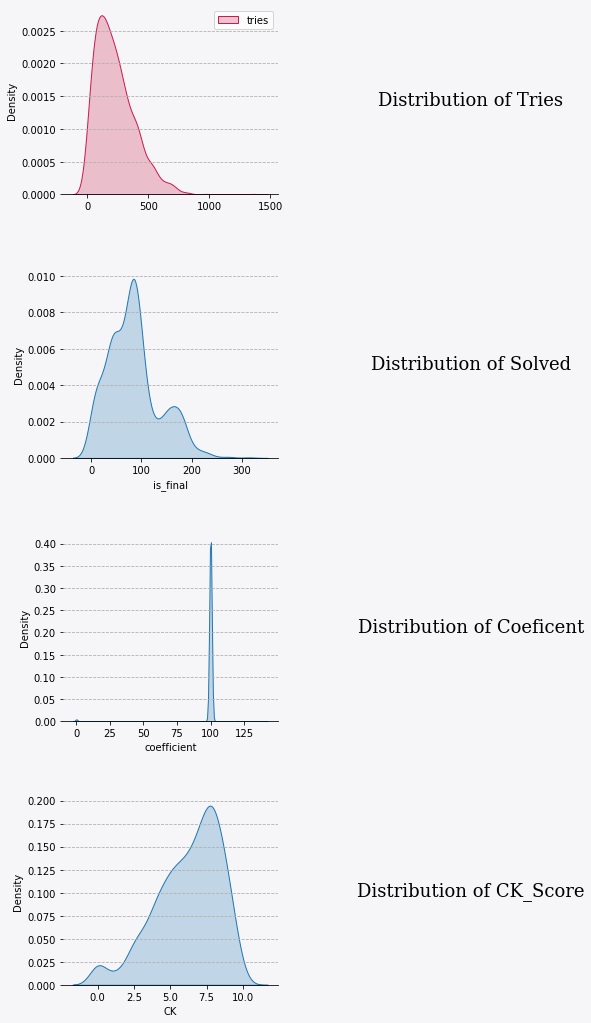

In [ ]:
fig= plt.figure(figsize = (20,18))
gs = fig.add_gridspec(4,4)
gs.update(wspace=0.4, hspace=0.4)

ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[0,1])
ax2 = fig.add_subplot(gs[1,0])
ax3 = fig.add_subplot(gs[1,1])
ax4 = fig.add_subplot(gs[2,0])
ax5 = fig.add_subplot(gs[2,1])
ax6 = fig.add_subplot(gs[3,0])
ax7 = fig.add_subplot(gs[3,1])
axes=[ax0,ax1,ax2,ax3,ax4,ax5, ax6, ax7]
background_color = '#f6f5f7'

for i in axes:
    i.set_facecolor(background_color)
fig.patch.set_facecolor(background_color) 
sns.kdeplot(ax = ax0, data=raw_tries,shade=True,palette='rocket', label = 'tries') # Distributions
ax0.grid(linestyle='--', axis='y')
ax1.text(0.5,0.5,'Distribution of Tries',horizontalalignment = 'center',verticalalignment = 'center',fontsize = 18,fontfamily='serif')

fig.patch.set_facecolor(background_color) 
sns.kdeplot(ax= ax2, data=raw_solved,shade=True,palette='rocket', label = 'Solved') # Distributions
ax2.grid(linestyle='--', axis='y')
ax3.text(0.5,0.5,'Distribution of Solved',horizontalalignment = 'center',verticalalignment = 'center',fontsize = 18,fontfamily='serif')

fig.patch.set_facecolor(background_color) 
sns.kdeplot(ax = ax4, data=raw_coef,shade=True,palette='rocket', label = 'coefs') # Distributions
ax4.grid(linestyle='--', axis='y')
ax5.text(0.5,0.5,'Distribution of Coeficent',horizontalalignment = 'center',verticalalignment = 'center',fontsize = 18,fontfamily='serif')

fig.patch.set_facecolor(background_color) 
sns.kdeplot(ax= ax6, data=raw_ck,shade=True,palette='rocket', label = 'CK_Score') # Distributions
ax6.grid(linestyle='--', axis='y')
ax7.text(0.5,0.5,'Distribution of CK_Score',horizontalalignment = 'center',verticalalignment = 'center',fontsize = 18,fontfamily='serif')


axes1=[ax1,ax3,ax5,ax7]
for i in axes1:
    i.spines["bottom"].set_visible(False)
    i.spines["left"].set_visible(False)
    i.set_xlabel("")
    i.set_ylabel("")
    i.set_xticklabels([])
    i.set_yticklabels([])
    i.tick_params(left=False, bottom=False)
# removing spines of figures
for i in ["top","left","right"]:
    ax0.spines[i].set_visible(False)
    ax1.spines[i].set_visible(False)
    ax2.spines[i].set_visible(False)
    ax3.spines[i].set_visible(False)
    ax4.spines[i].set_visible(False)
    ax5.spines[i].set_visible(False)
    ax6.spines[i].set_visible(False)
    ax7.spines[i].set_visible(False)

# Nhận xét từ biểu đồ:

*   Giá trị của Tries tăng mạnh ở từ 0 tới 200 và giảm dần tới 800, tương tự với CK_Score tăng dần từ 2 cho tới 8 và giảm dần tới 12. Có sự giống nhau ở sự biến thiên của biểu đồ
*   Dạng biểu đồ của coeficent khác hoàn toàn với biểu đồ CK_Score nên sẽ không ảnh hưởng tới điểm cuối kỳ
*   Đa số sinh viên thử sức - tries trong khoản 200 lần nhưng tất cả bài tập được giải quyết - solved chỉ nằm khoảng một nửa.
*   Số lượng vấn đề giải được và số lần thử cùng với kết quả của điểm cuối kỳ thể hiện một tác động lên nhau rất rõ

*==> Sử dụng Solved và Tries làm features*



**Visualize categorical data**

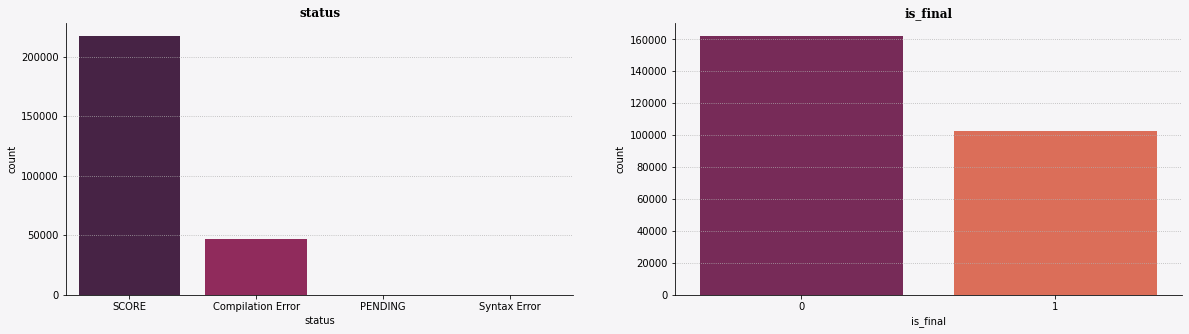

In [ ]:
fig=plt.figure(figsize=(20,23))
background_color = '#f6f5f7'
fig.patch.set_facecolor(background_color) 
data_categorical = pd.concat([raw_status, raw_true_final], axis=1)
for indx,val in enumerate(data_categorical.columns):
    ax=plt.subplot(4,2,indx+1)
    ax.set_facecolor(background_color)
    ax.set_title(val,fontweight='bold',fontfamily='serif')
    for i in ['top','right']:
        ax.spines[i].set_visible(False)
    ax.grid(linestyle=':',axis='y')
    sns.countplot(data_categorical[val],palette='rocket')

#2. PRE-PROCESSING DATA
<a name='process'></a>
##2.1 Create new data frame:

In [ ]:
User_Id = data.groupby('user_id').sum()
User_Id

,assignment_id,problem_id,is_final,pre_score,coefficient
user_id,,,,,
1,0,451,2,10000,200.0
4,0,8518,38,466000,5400.0
5,613,748,5,30000,600.0
6,673,34030,88,965637,13000.0
7,0,1700,2,18843,500.0
...,...,...,...,...,...
1860,16318,18323,48,405440,7600.0
1862,1473,596,6,40000,1200.0
1864,35685,37148,63,563292,18700.0


remove column: id, created_at, updated_at, file_name, language_id


In [ ]:
data.head(10).T

,0,1,2,3,4,5,6,7,8,9
assignment_id,0,0,0,0,0,0,0,0,0,0
problem_id,3,4,5,5,5,5,6,7,8,9
user_id,4,4,4,4,4,4,4,4,4,4
is_final,1,1,0,0,0,0,1,1,1,1
status,SCORE,SCORE,Compilation Error,Compilation Error,Compilation Error,Compilation Error,SCORE,SCORE,SCORE,SCORE
pre_score,10000,10000,0,0,0,0,10000,10000,10000,10000
coefficient,100,100,100,100,100,100,100,100,100,100


index = user_id

columns = ['tries'] tổng số lần submit của một user_id

In [ ]:
# Create a dataframe with index is user_id and data is number of  number of each user_id appear
tries = pd.DataFrame({'tries' : data['user_id'].value_counts()})
tries = tries.sort_index()
tries

,tries
1,2
4,54
5,6
6,130
7,5
...,...
1860,76
1862,12
1864,187
1865,99


index = user_id

lọc tìm những lần solved/user_id

In [ ]:
#@title
# Create dataframe[['user_id', 'is_final', 'pre_score']]
user_isfinal_score = data[['user_id', 'is_final', 'pre_score']]
user_isfinal_score

,user_id,is_final,pre_score
0,4,1,10000
1,4,1,10000
2,4,0,0
3,4,0,0
4,4,0,0
...,...,...,...
264601,1796,0,0
264602,1796,0,0
264603,1796,1,10000
264604,255,1,6250


In [ ]:
# Get data has 'is_final' = 1 and score = 10000 => solved problem
isfinal_submit = user_isfinal_score[user_isfinal_score['is_final'] > 0]
isfinal_submit = user_isfinal_score[user_isfinal_score['pre_score'] == 10000]
isfinal_submit = isfinal_submit.groupby('user_id').sum()
isfinal_submit

,is_final,pre_score
user_id,,
1,1,10000
4,37,440000
5,3,30000
6,85,890000
11,9,190000
...,...,...
1860,28,290000
1862,4,40000
1864,28,300000


In [ ]:
# Cat dataframe
new_data_frame = pd.concat([tries, isfinal_submit], axis=1)
new_data_frame

,tries,is_final,pre_score
1,2,1.0,10000.0
4,54,37.0,440000.0
5,6,3.0,30000.0
6,130,85.0,890000.0
7,5,NaN,NaN
...,...,...,...
1860,76,28.0,290000.0
1862,12,4.0,40000.0
1864,187,28.0,300000.0
1865,99,10.0,100000.0


In [ ]:
new_data_frame.rename(columns={'is_final':'solved', 'pre_score':'total_true_score'}, inplace=True)
new_data_frame['user_id'] = new_data_frame.index
first_column = new_data_frame.pop('user_id')
new_data_frame.insert(0, 'user_id', first_column)
new_data_frame

,user_id,tries,solved,total_true_score
1,1,2,1.0,10000.0
4,4,54,37.0,440000.0
5,5,6,3.0,30000.0
6,6,130,85.0,890000.0
7,7,5,NaN,NaN
...,...,...,...,...
1860,1860,76,28.0,290000.0
1862,1862,12,4.0,40000.0
1864,1864,187,28.0,300000.0
1865,1865,99,10.0,100000.0


In [ ]:
score_CK = data_score[['id', 'CK']]
score_CK.set_index('id', inplace=True)
new_data = pd.concat([new_data_frame, score_CK], axis=1)
new_data['user_id'] = new_data.index
new_data

,user_id,tries,solved,total_true_score,CK
1,1,2.0,1.0,10000.0,NaN
4,4,54.0,37.0,440000.0,NaN
5,5,6.0,3.0,30000.0,NaN
6,6,130.0,85.0,890000.0,NaN
7,7,5.0,NaN,NaN,NaN
...,...,...,...,...,...
1862,1862,12.0,4.0,40000.0,7.5
1864,1864,187.0,28.0,300000.0,NaN
1865,1865,99.0,10.0,100000.0,7.5
1866,1866,NaN,NaN,NaN,5.0


In [ ]:
#find NaN values and replace it with 0
def count_missing_values(data):
  num_of_miss_data = data.isnull().sum()
  missing_data = pd.concat([num_of_miss_data], axis=1, keys = ['Number of missing value'])
  return missing_data
count_missing_values(new_data)


,Number of missing value
user_id,0
tries,122
solved,142
total_true_score,142
CK,361


In [ ]:
new_data = new_data.drop(columns= 'total_true_score')

In [ ]:
new_data

,user_id,tries,solved,CK
1,1,2.0,1.0,NaN
4,4,54.0,37.0,NaN
5,5,6.0,3.0,NaN
6,6,130.0,85.0,NaN
7,7,5.0,NaN,NaN
...,...,...,...,...
1862,1862,12.0,4.0,7.5
1864,1864,187.0,28.0,NaN
1865,1865,99.0,10.0,7.5
1866,1866,NaN,NaN,5.0


In [94]:
#fill missing value of column 'tries'
new_data['tries'] = new_data['tries'].interpolate(method = 'pad', limit = 3)
new_data['tries'] = new_data['tries'].fillna(int(np.mean(new_data['tries'])))

In [95]:
#fill missing value of column 'solved'
new_data['solved'] = new_data['solved'].interpolate(method = 'pad', limit = 3)
new_data['solved'] = new_data['solved'].fillna(int(np.mean(new_data['solved'])))

In [96]:
#create column solved/tries
new_data['solved/tries'] = round(new_data['solved']/new_data['tries'], 2)

In [97]:
#convert type of data CK into numeric
new_data['CK'] = pd.to_numeric(new_data['CK'], errors='coerce')

In [98]:
columns_titles = ['user_id','solved', 'tries', 'solved/tries', 'CK']
new_data=new_data.reindex(columns=columns_titles)
new_data

,user_id,solved,tries,solved/tries,CK
1,1,1.0,2.0,0.50,NaN
4,4,37.0,54.0,0.69,NaN
5,5,3.0,6.0,0.50,NaN
6,6,85.0,130.0,0.65,NaN
7,7,85.0,5.0,17.00,NaN
...,...,...,...,...,...
1862,1862,4.0,12.0,0.33,7.5
1864,1864,28.0,187.0,0.15,NaN
1865,1865,10.0,99.0,0.10,7.5
1866,1866,10.0,99.0,0.10,5.0


In [112]:
data_to_predict = new_data[new_data.isna().any(axis=1)]
data_to_predict = data_to_predict[data_to_predict['solved/tries'] <= 1]
data_to_predict

,user_id,solved,tries,solved/tries,CK
1,1,1.0,2.0,0.50,NaN
4,4,37.0,54.0,0.69,NaN
5,5,3.0,6.0,0.50,NaN
6,6,85.0,130.0,0.65,NaN
11,11,9.0,50.0,0.18,NaN
...,...,...,...,...,...
1852,1852,1.0,20.0,0.05,NaN
1855,1855,63.0,134.0,0.47,NaN
1860,1860,28.0,76.0,0.37,NaN
1864,1864,28.0,187.0,0.15,NaN


In [113]:
data_to_predict
id_predict = data_to_predict["user_id"].to_numpy()
data_to_predict = data_to_predict.drop(['user_id'], axis = 1)

In [114]:
data_to_train = new_data.dropna()
data_to_train = data_to_train.drop(['user_id'], axis = 1)
data_to_train = data_to_train[data_to_train['solved/tries'] <= 1]

In [105]:
data_to_train

,solved,tries,solved/tries,CK
22,12.0,13.0,0.92,8.5
24,72.0,164.0,0.44,9.5
27,3.0,13.0,0.23,10.0
28,3.0,13.0,0.23,9.5
29,72.0,199.0,0.36,8.5
...,...,...,...,...
1857,37.0,55.0,0.67,4.0
1859,3.0,31.0,0.10,1.5
1862,4.0,12.0,0.33,7.5
1865,10.0,99.0,0.10,7.5


In [ ]:
#@title
#fill missing value of column 'CK'
# new_data['CK'] = new_data['CK'].interpolate(method = 'pad', limit = 3)
# new_data['CK'] = pd.to_numeric(new_data['CK'], errors='coerce')
# new_data['CK'] = new_data['CK'].fillna(int(np.mean(new_data['CK'])))

In [106]:
data_to_train.to_csv('/content/data_train.csv')
data_to_predict.to_csv('/content/data_test.csv')

#visualize data after pre-processing

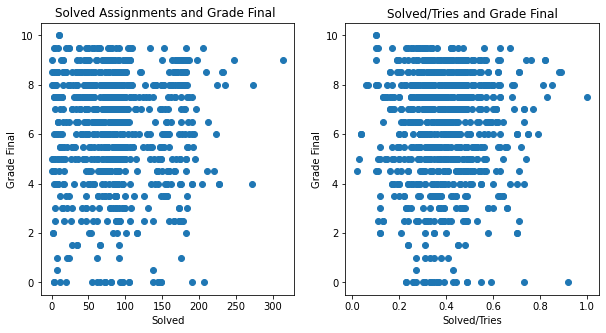

In [115]:
import matplotlib.pyplot as plt
fig, (axs1, axs2) = plt.subplots(1,2, figsize = (10,5))
axs1.scatter(x = data_to_train['solved'], y = data_to_train['CK'].sort_values())


axs1.set_title("Solved Assignments and Grade Final ")
axs1.set(xlabel='Solved', ylabel='Grade Final')


axs2.scatter(x = data_to_train['solved/tries'], y = data_to_train['CK'].sort_values())


axs2.set_title("Solved/Tries and Grade Final")
axs2.set(xlabel='Solved/Tries', ylabel='Grade Final')

plt.show()

#3 TRANING MODEL AND TESTING
<a name='model'></a>

Spliting model

In [116]:
X = np.array(data_to_train['solved/tries']).reshape(-1,1)
y = np.array(data_to_train['CK'])
y

array([ 8.5,  9.5, 10. ,  9.5,  8.5,  9. ,  6.5,  4.5,  7. ,  7.5,  8. ,
        8. ,  7.5,  6. ,  5. ,  7.5,  4. ,  3. ,  5.5,  4.5,  6. ,  6. ,
        4.5,  8. ,  7. ,  6.5,  4.5,  9. ,  9.5,  5.5,  9. ,  2. ,  6.5,
        7.5,  6. ,  0. ,  8.5,  3.5,  8.5,  3. ,  3.5,  5.5,  9. ,  7.5,
        8.5,  3.5,  6. ,  8. ,  7.5,  5.5,  6. ,  8. ,  5. ,  5.5,  7. ,
        9. ,  5. ,  7. ,  8. ,  5.5,  9. ,  5.5,  9.5,  8. ,  7. ,  8.5,
        7.5,  7. ,  9. ,  4.5,  4.5,  4.5,  6. ,  0. ,  8. ,  0. ,  9. ,
        0. ,  7. ,  4. ,  0. ,  7.5,  6. ,  0. ,  7.5,  5.5,  9. ,  8. ,
        5.5,  6.5,  5.5,  6.5,  4. ,  6.5,  5.5,  4.5,  5.5,  1.5,  6.5,
        7. ,  8. ,  4.5,  7. ,  9.5,  7.5,  8.5,  6.5,  5. ,  5. ,  8. ,
        6.5,  9. ,  5. ,  7.5,  0. ,  8. ,  4. ,  7. ,  6. ,  7. ,  4. ,
        4.5,  4. ,  8. ,  2.5,  8. ,  9. ,  8. ,  4.5,  0. ,  8. ,  8.5,
        7.5,  8.5,  6.5,  5. ,  9. ,  6. ,  6.5,  8. ,  9.5,  7. ,  5. ,
        7. ,  6.5,  2.5,  2.5,  8. ,  7.5,  4.5,  6

In [117]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
lr_model = LinearRegression().fit(x_train, y_train)
predicted = lr_model.predict(x_test)
print(lr_model.score(x_test, y_test))
# acc = accuracy_score(y_test, predicted)

0.01279514792169789


In [118]:
x_predict = np.array(data_to_predict['solved/tries']).reshape(-1,1)

In [119]:
#submit prediction
y_predict = lr_model.predict(x_predict)
y_predict
result = {
    "id": id_predict,
    "stroke" :y_predict
}
result_submit = pd.DataFrame(result)
result_submit

,id,stroke
0,1,5.973872
1,4,5.589653
2,5,5.973872
3,6,5.670541
4,11,6.620979
...,...,...
347,1852,6.883866
348,1855,6.034539
349,1860,6.236759
350,1864,6.681645
